In [1]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, f1_score,precision_score
from sklearn.decomposition import FastICA, PCA,TruncatedSVD
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from pathlib import *
import numpy as np
import scipy as sp
import pandas as pd
import random
import json
import os
import math

In [2]:

BASE_DIR = "/net/projects/scratch/winter/valid_until_31_July_2022/krumnack/animal-communication-data/Chimp_IvoryCoast/manually_verified_2s/chimp_only_23112020_with_ids"
file_path = "/net/projects/scratch/winter/valid_until_31_July_2022/ybrima/data/data_chimp_preprocessed.npz"
selected_path = "/net/projects/scratch/winter/valid_until_31_July_2022/ybrima/data/data_chimp.csv"
SAMPLE_RATE = 44100
N_FFT = 2048
HOP_LENGTH =  512
num_mfcc=32

In [5]:
def sanitize(INPUT_PATH):
    ds =  {'file': [],'class': [],'duration':[], 'sr':[]}
    for f in Path(INPUT_PATH).glob("**/*.wav"):
        ds['file'].append(f)
        f =  str(f)
        y,sr =  librosa.load(f, sr=None)
        ds['duration'].append((1/sr) * len(y))
        ds['sr'].append(sr)
        clx = f[f.rfind("/")+12:][:f[f.rfind("/")+12:].index('_')]
        if(len(clx) > 3):
            ds['class'].append(clx.split('-')[0])
        else:
            ds['class'].append(clx)
    data =  pd.DataFrame(ds)
    df  = data[data['class'].map(data['class'].value_counts()) > 150]
    return df

In [6]:
df =  sanitize(BASE_DIR)

In [8]:
df.to_csv(selected_path,index=False)

In [9]:
df =  pd.read_csv(selected_path)

In [3]:
CLASSES = ['kub','woo','rom','uta','jac','ish','sum','jul','kin','Kuba']

In [16]:
def preprocess():
    ds =  {'data': [],'class': [], 'sr': [], "spec" : []}
    max_idx = df[df['duration'] == df['duration'].max()].index
    if(len(max_idx) > 1):
        max_idx =  max_idx[0]
    r = df.iloc[max_idx]
    filename = r['file']
    ymax,sr = librosa.load(filename, sr=r['sr'])
    for k in range(df.shape[0]):
        r = df.iloc[k]
        y,sr = librosa.load(r['file'], sr=r['sr'])
        dff =  int(np.ceil( len(ymax) - len(y) ) / 2)
        a  = np.lib.pad(y, (int(np.floor(dff)) ,), 'symmetric')
        if(len(a)  ==  len(ymax)):
            ds['data'].append(a)
            ds['class'].append(CLASSES.index(r['class']))
            ds['sr'].append(sr)
            D = librosa.amplitude_to_db(np.abs(librosa.stft(a,n_fft=2048, hop_length=HOP_LENGTH)), ref=np.max)
            ds['spec'].append(D)
    X =  np.array(ds['data'])
    y = np.array(ds['class'])
    Z  =  np.array(ds['spec'])
    sr = np.array(ds['sr'])
    np.savez(file_path,X=X,y=y,sr=sr,Z = Z)
    print(f"Data preprocessed successfully and saved to {file_path}")

In [17]:
preprocess()

Data preprocessed successfully and saved to /net/projects/scratch/winter/valid_until_31_July_2022/ybrima/data/data_chimp_preprocessed.npz


In [33]:
data =  np.load(file_path,allow_pickle=True)
X = data['X']
Z = data['Z']
y = data['y']
sr = data['sr']

In [22]:
Z.reshape(6140,-1).shape

(6140, 177325)

In [20]:
print(X.shape, Z.shape)

(6140, 88200) (6140, 1025, 173)


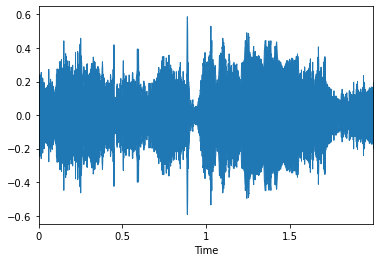

In [15]:
librosa.display.waveplot(X[0], sr=sr[0])

In [24]:
pca =  PCA(n_components=3, random_state=np.random.seed(42))
X_pca = pca.fit_transform(Z.reshape(6140,-1))

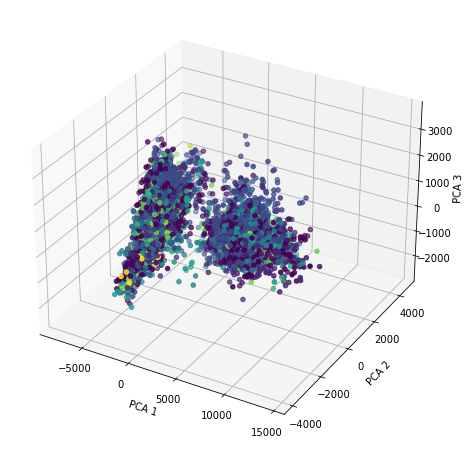

In [39]:
fig = plt.figure(figsize=(14,8))
ax =  fig.add_subplot(projection='3d')
ax.scatter3D(X_pca[:,0],X_pca[:,1],X_pca[:,2],c=list(y))
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_xlabel("PCA 1")
plt.show()

In [26]:
ica =  FastICA(n_components=3, random_state=np.random.seed(42))
X_ica = ica.fit_transform(Z.reshape(6140,-1))

In [30]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

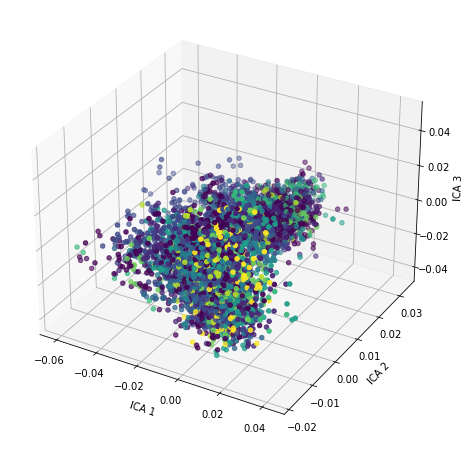

In [38]:
fig = plt.figure(figsize=(14,8))
ax =  fig.add_subplot(projection='3d')
ax.scatter3D(X_ica[:,0],X_ica[:,1],X_ica[:,2],c=list(y))
ax.set_ylabel("ICA 2")
ax.set_zlabel("ICA 3")
ax.set_xlabel("ICA 1")
plt.show()

In [32]:
HOP_LENGTH =  512

In [40]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(X[0],n_fft=2048, hop_length=HOP_LENGTH)), ref=np.max)
D.shape

(1025, 173)

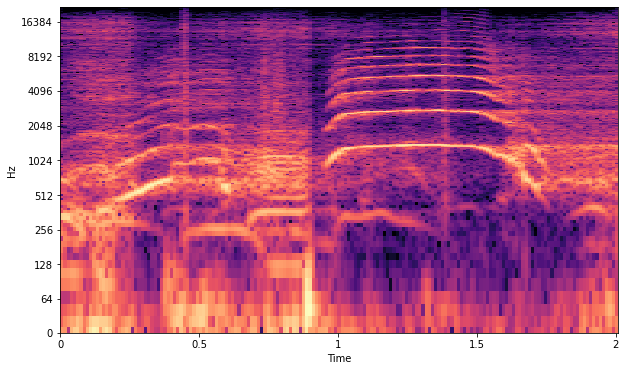

In [41]:
fig = plt.figure(figsize=(10,6))
librosa.display.specshow(D, sr = sr[0], y_axis='log', x_axis='time', hop_length=HOP_LENGTH )
plt.show()

In [29]:
def make_model(input_shape,num_output):
    
    inputs = keras.Input(shape=input_shape)
    x =  keras.layers.Dense(32,activation="relu",kernel_regularizer=keras.regularizers.l2(0.2))(inputs)

    x =   keras.layers.Dense(64,activation="relu",kernel_regularizer=keras.regularizers.l2(0.2))(x)
    x =  keras.layers.Dropout(0.3)(x)

    x =   keras.layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.l2(0.2))(x)
    x =  keras.layers.Dropout(0.3)(x)

    x =   keras.layers.Dense(256,activation="relu",kernel_regularizer=keras.regularizers.l2(0.2))(x)
    x =  keras.layers.Dropout(0.3)(x)

    x =   keras.layers.Dense(128,activation="relu",kernel_regularizer=keras.regularizers.l2(0.2))(x)
    x =  keras.layers.Dropout(0.3)(x)

    x =   keras.layers.Dense(64,activation="relu",kernel_regularizer=keras.regularizers.l2(0.2))(x)
    x =  keras.layers.Dropout(0.3)(x)

    x =   keras.layers.Dense(32,activation="relu",kernel_regularizer=keras.regularizers.l2(0.2))(x)
    x =  keras.layers.Dropout(0.3)(x)

    outputs =  keras.layers.Dense(num_output,activation="softmax")(x)

    model =  keras.Model(inputs=inputs,outputs=outputs,name="deepspeaker")

    model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
    )
    return model

In [31]:
def build_model(input_shape,num_output):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())





    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(num_output, activation='softmax'))
    
    model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.RMSprop(),
    metrics=["accuracy"],
    )
    return model

In [32]:
Z =  Z.reshape(Z.shape[0],-1)

input_shape =  (Z.shape[1],)
num_output = len(CLASSES)

model =  build_model(input_shape,num_output)

ValueError: Input 0 of layer "conv2d" is incompatible with the layer: expected min_ndim=4, found ndim=2. Full shape received: (None, 177325)

In [14]:
model.summary()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.3,shuffle=True)

In [19]:
history = model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.2)

Epoch 1/2
108/108 [==============================] - ETA: 0s - loss: 238.1432 - accuracy: 0.2211

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])